# Introduction

Recently, artificial intelligence (AI) has also been widely employed in the field of healthcare. Particularly, AI has contributed to medical diagnosis in radiology by convolutional neural network (CNN). CNN has a great capacity to classify images such as X-ray images by way of supervised learning. It is expected that AI may facilitate the quality of healthcare services and reduce workloads for healthcare professionals.

This time, a png dataset is used instead of the original RSMA dataset, because Tensorflow cannot directly read dicom file. The dataset is created by and available at [RSNA Breast Cancer Detection - 512x512 pngs](https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-512-pngs).

# Import Libraries

ResNet50 is a greatly popular and frequently used CNN model for medical AI research. The results of image classification performance by an AI model is generally estimated by classification report and confusion matrix.

In [1]:
# TensorFlow libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# basic libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import glob
from glob import glob

# Read the CSV File

Next, we get the paths to access the image data and csv data. The csv data include various information about patients, such as biopsy, malignant cancer, and invasive cancer.

In [2]:
# the path to the image data
RSNA_512_path = '/kaggle/input/rsna-breast-cancer-512-pngs'

In [3]:
# Read the csv data.
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


## Attention

Generally, mammography is conducted with 2 views (from 2 angles), because **the position of breast cancer is various, although the upper outer quadrant of the breast is the most common site of breast cancer occurrence**. But the shape of the breast is almost the same regardless of different views. Moreover, the left and right breast generally have the same view. Therefore, we ignore the laterality and view for the machine learning purpose. The patient of the test data has no implant, so patients having implant can be excluded from the train data set. However, this patient has no risk of false positive for cancer because of implant. Although it is unknown whether the other patients in the hidden test data set have an implant, generally few patients have implant. Thus, implant appears to have little influence on this machine learning.

In [4]:
# the number of total patients
len(df_train)

54706

In [5]:
# the number of patients having implant
len(df_train[df_train['implant'] == 1])

1477

In [6]:
# the number of patients without malignant cancer
len(df_train[df_train['cancer'] == 0])

53548

In [7]:
# the number of patient who took biopsy
len(df_train[df_train['biopsy'] == 1])

2969

In [8]:
# the number of patients having malignant cancer
len(df_train[df_train['cancer'] == 1])

1158

In [9]:
# the number of patients whose malignant cancer is invasive
len(df_train[df_train['invasive'] == 1])

818

In [10]:
# the same as above
len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])

818

<AxesSubplot:xlabel='class', ylabel='count'>

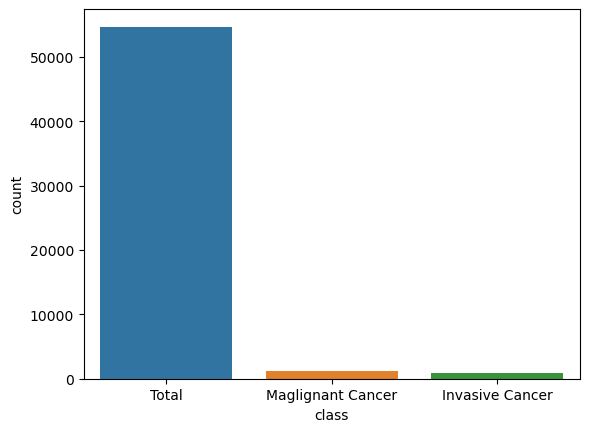

In [11]:
# Most of the cases are normal or not-malignant cancer. Thus, physicians sometimes overlook cancer.
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train) , ['Maglignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

<AxesSubplot:xlabel='class', ylabel='count'>

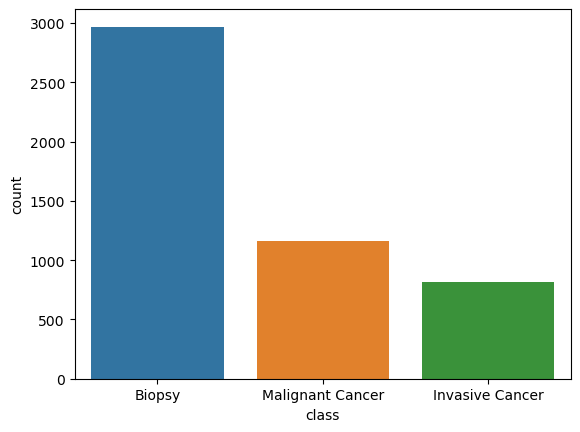

In [12]:
# Around 3000 patient took biopsy and malignant cancer was found from some of them.
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [13]:
# the number of not-malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])

1811

In [14]:
# the number of malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])

1158

<AxesSubplot:xlabel='class', ylabel='count'>

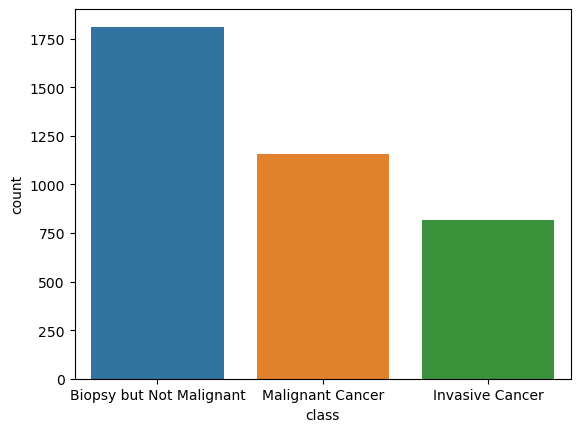

In [15]:
# 60% of biopsy resulted in not-malignanct cancer.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

## Attention

This is a very difficult question whether **"not-malignant cancer" cases should be selected from (1)"the whole patients without malignant cancer," (2)"the whole patients without taking biopsy," or (3)"patients with biopsy but without malignant cancer." The first choice is optimal for initial screening for general people**, most of whom are healthy.

People generally take biopsy because not only of suspected mammography image of breast cancer, but also of their clinical findings or family history. Thus, images from **"patients with biospy but without malignant cancer" may be totally healthy or may include benign cancer or other diseases, such as inflammation**. Therefore, **the second choice may be optimal, if the initial screening is only conducted for detection of malignant breast cancer**, and the patients do not suffer from any other diseases.

**The third choice is optimal** for special screening for suspected cases of malignanct cancer. This is particularly useful **when it is supected that a patient might suffer malignant cancer**. This AI would be used before biopsy is conducted.

In this competition, the purpose of screening is not suffiently clear, because the test data do not inlude information as to biopsy. This time we take the third choice, but another choice might be better for the purpose of the competition.

In [16]:
# The not-malignant cancer cases were limited into biopsy cases.
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0,B,49,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False


In [17]:
# The number of positive (malignant) and negative (not-malignat) cases should be the same
# to create a balanced dataset.
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


<AxesSubplot:xlabel='class', ylabel='count'>

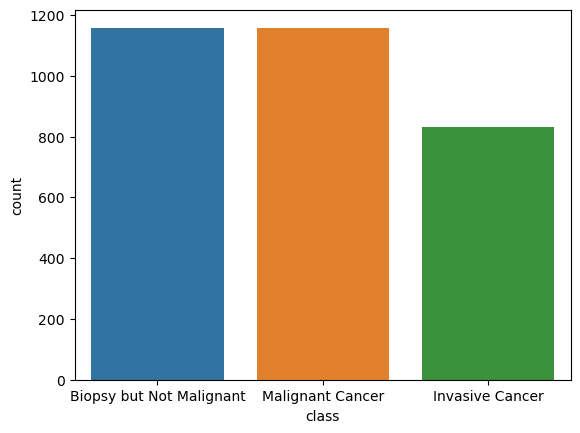

In [18]:
# Generally, invasive cancer is confirmed by biopsy, not by mammography.
# Maybe it is also extremely difficult for AI to detect invasive cancer from mammography.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(DF_train[DF_train['cancer'] == 1]), ['Invasive Cancer'] *  len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

# Create the Path to Each Image

In [19]:
# Create the path to each image.
for i in range(len(DF_train)):
    DF_train.loc[i, 'path'] = os.path.join(RSNA_512_path + '/' + str(DF_train.loc[i, 'patient_id']) + '_' + str(DF_train.loc[i, 'image_id']) + '.png')
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,14990,772144878,L,MLO,58.0,0,1,0,0.0,0,B,93,True,/kaggle/input/rsna-breast-cancer-512-pngs/1499...
1,1,1468,1161772447,R,CC,67.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1468...
2,1,22051,1491304433,L,MLO,70.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2205...
3,1,55898,1121898241,L,MLO,45.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5589...
4,1,33117,384266027,R,CC,71.0,0,1,0,0.0,1,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3311...


In [20]:
# a sample path
DF_train.loc[0, 'path']

'/kaggle/input/rsna-breast-cancer-512-pngs/14990_772144878.png'

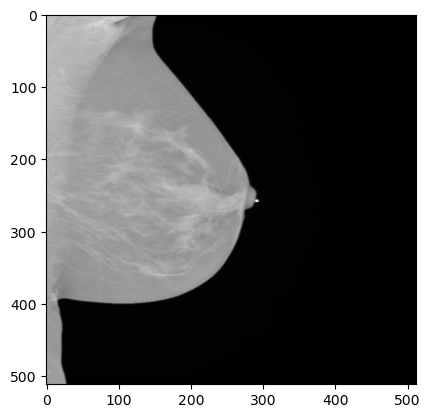

In [21]:
# a sample image
img = cv2.imread(DF_train.loc[0, 'path'])
plt.imshow(img, cmap = 'gray')

In [22]:
img

array([[[189, 189, 189],
        [190, 190, 190],
        [189, 189, 189],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[192, 192, 192],
        [191, 191, 191],
        [187, 187, 187],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[185, 185, 185],
        [190, 190, 190],
        [193, 193, 193],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[161, 161, 161],
        [158, 158, 158],
        [159, 159, 159],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[160, 160, 160],
        [159, 159, 159],
        [160, 160, 160],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[160, 160, 160],
        [160, 160, 160],
        [158, 158, 158],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [23]:
img.shape

(512, 512, 3)

# Divide the Data into Training and Validation

This time we devide the data into training and validation data, because test data originally exist.

In [24]:
# Normal and cancer images must be equally distrubuted.
train_df, val_df = train_test_split(DF_train, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = DF_train[['cancer']])

print('train', train_df.shape[0], 'validation', val_df.shape[0])
print('train', train_df['cancer'].value_counts())
print('validation', val_df['cancer'].value_counts())
train_df.sample(1)

train 1621 validation 695
train 1    811
0    810
Name: cancer, dtype: int64
validation 0    348
1    347
Name: cancer, dtype: int64


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
178,1,17765,1688484514,R,CC,49.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1776...


In [25]:
# training data
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
2110,1,25550,1138491602,L,MLO,77.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2555...
1564,1,30836,714251521,L,CC,48.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3083...
553,1,38144,2075998552,R,MLO,62.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3814...
757,1,56672,1450201583,L,CC,70.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5667...
1873,2,40511,1210260446,L,CC,68.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/4051...


In [26]:
# validation data
val_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
763,2,35526,1808078339,L,CC,60.0,0,1,0,NaN,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-512-pngs/3552...
933,1,42214,1171532720,R,CC,71.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4221...
493,2,60800,2102007469,L,CC,51.0,0,1,0,NaN,0,NaN,48,True,/kaggle/input/rsna-breast-cancer-512-pngs/6080...
2145,1,35864,1558139643,L,MLO,75.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3586...
1300,2,10638,1696075167,L,CC,63.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/1063...


In [27]:
# Pick up normal images from the training data.
train_df_normal = train_df[train_df['cancer'] == 0].reset_index(drop = True)
print(len(train_df_normal))
train_df_normal.head()

810


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,38144,2075998552,R,MLO,62.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3814...
1,1,56672,1450201583,L,CC,70.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5667...
2,1,47186,1418290508,R,MLO,63.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4718...
3,1,36570,1126989566,R,MLO,43.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3657...
4,1,29756,94980815,L,CC,56.0,0,1,0,0.0,0,B,170,True,/kaggle/input/rsna-breast-cancer-512-pngs/2975...


In [28]:
# Pick up cancer images from the training data.
train_df_cancer = train_df[train_df['cancer'] == 1].reset_index(drop = True)
print(len(train_df_cancer))
train_df_cancer.head()

811


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,25550,1138491602,L,MLO,77.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2555...
1,1,30836,714251521,L,CC,48.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3083...
2,2,40511,1210260446,L,CC,68.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/4051...
3,1,28620,669303826,R,MLO,55.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2862...
4,2,12282,2025746473,L,CC,63.0,1,1,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/1228...


In [29]:
# Pick up normal images from the validation data.
val_df_normal = val_df[val_df['cancer'] == 0].reset_index(drop = True)
print(len(val_df_normal))
val_df_normal.head()

348


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,35526,1808078339,L,CC,60.0,0,1,0,NaN,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-512-pngs/3552...
1,1,42214,1171532720,R,CC,71.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4221...
2,2,60800,2102007469,L,CC,51.0,0,1,0,NaN,0,NaN,48,True,/kaggle/input/rsna-breast-cancer-512-pngs/6080...
3,1,44728,1174763673,L,CC,50.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4472...
4,1,61267,1233033222,R,MLO,62.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6126...


In [30]:
# Pick up cancer images from the validation data.
val_df_cancer = val_df[val_df['cancer'] == 1].reset_index(drop = True)
print(len(val_df_cancer))
val_df_cancer.head()

347


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,35864,1558139643,L,MLO,75.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3586...
1,2,10638,1696075167,L,CC,63.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/1063...
2,2,14941,1634151852,R,CC,68.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1494...
3,1,15078,1167308429,R,CC,67.0,1,1,1,0.0,0,B,170,False,/kaggle/input/rsna-breast-cancer-512-pngs/1507...
4,1,26232,892289164,L,MLO,55.0,1,1,0,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2623...


**We have to store the 4 datasets in each folder to be used for machine learing of TensorFlow AI model.**

In [31]:
import shutil
# Define the destination directory.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in train_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [32]:
# Define the destination directory.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in train_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [33]:
# Define the destination directory.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in val_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [34]:
# Define the destination directory.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in val_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

# Sample Images

In [35]:
import glob
normal_train_images = glob.glob('/kaggle/working/train/normal/*.png')
cancer_train_images = glob.glob('/kaggle/working/train/cancer/*.png')

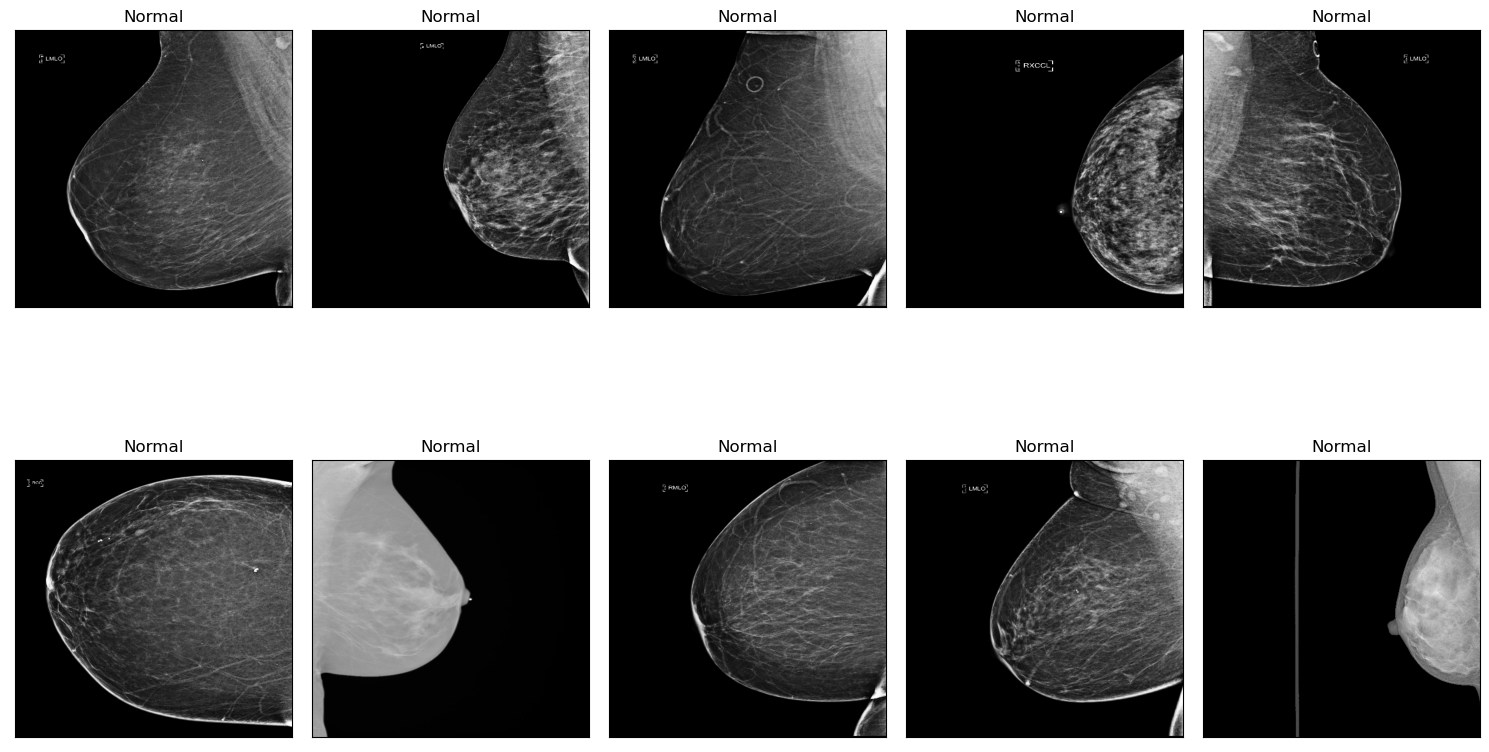

In [36]:
# See normal images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    ax.imshow(img)
    ax.set_title('Normal')
fig.tight_layout()    

plt.show()

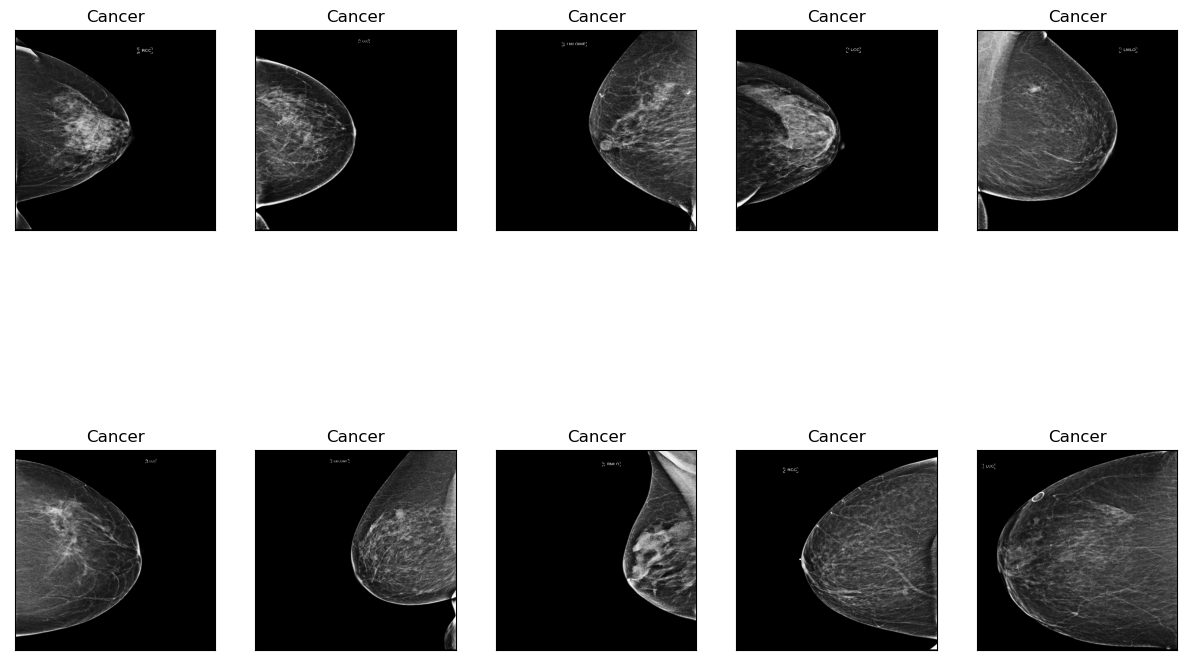

In [37]:
# See cancer images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(cancer_train_images[i])
    ax.imshow(img)
    ax.set_title('Cancer')
    
plt.show()

# Create Image data Generators

The dataset has already been divided into train and validation datasets, and each dataset includes normal and cancer image files. Thus, image data generators were easily created. 

In [38]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)

In [39]:
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (512, 512),
        batch_size = 16,
        class_mode = 'binary'
)

Found 1224 images belonging to 2 classes.
Found 606 images belonging to 2 classes.


# Define the Model (Transfer Learning)

Here, ResNet50V2 was employed as the base model for transfer learning. It would be also possible to conduct fine tuning with the model. The choice of hyperparameters depends on the type of task by machine learning. Sigmoid, adam, and binary cross entropy were selected for the final activation function, optimizer, and loss function, respectively.

In [40]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

94668760/94668760 [==============================] - 1s 0us/step


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
______________________________________

# Train the Model

The model was trained with the train and validation data. Early stopping was added to prevent overfitting. In fact, it might be preferable to set the larger number of epochs.

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15
20/20 [==============================] - 56s 2s/step - loss: 0.7489 - accuracy: 0.5260 - val_loss: 0.6570 - val_accuracy: 0.6007
Epoch 2/15
20/20 [==============================] - 45s 2s/step - loss: 0.6533 - accuracy: 0.6375 - val_loss: 0.6256 - val_accuracy: 0.6436
Epoch 3/15
20/20 [==============================] - 44s 2s/step - loss: 0.6565 - accuracy: 0.5974 - val_loss: 0.6172 - val_accuracy: 0.6568
Epoch 4/15
20/20 [==============================] - 45s 2s/step - loss: 0.6320 - accuracy: 0.6266 - val_loss: 0.6059 - val_accuracy: 0.6502
Epoch 5/15
20/20 [==============================] - 44s 2s/step - loss: 0.6492 - accuracy: 0.6201 - val_loss: 0.6939 - val_accuracy: 0.6056
Epoch 6/15
20/20 [==============================] - 46s 2s/step - loss: 0.6561 - accuracy: 0.6141 - val_loss: 0.6185 - val_accuracy: 0.6518
Epoch 7/15
20/20 [==============================] - 44s 2s/step - loss: 0.6218 - accuracy: 0.6445 - val_loss: 0.6152 - val_accuracy: 0.6353
Epoch 8/15
20/20 [==

# Save the Model

In [43]:
model.save('mammography_pred_model.h5')

# Model Metrics

The accuracy and loss were calculated for both train and validation data in the model training process.

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss

Text(0, 0.5, 'loss')

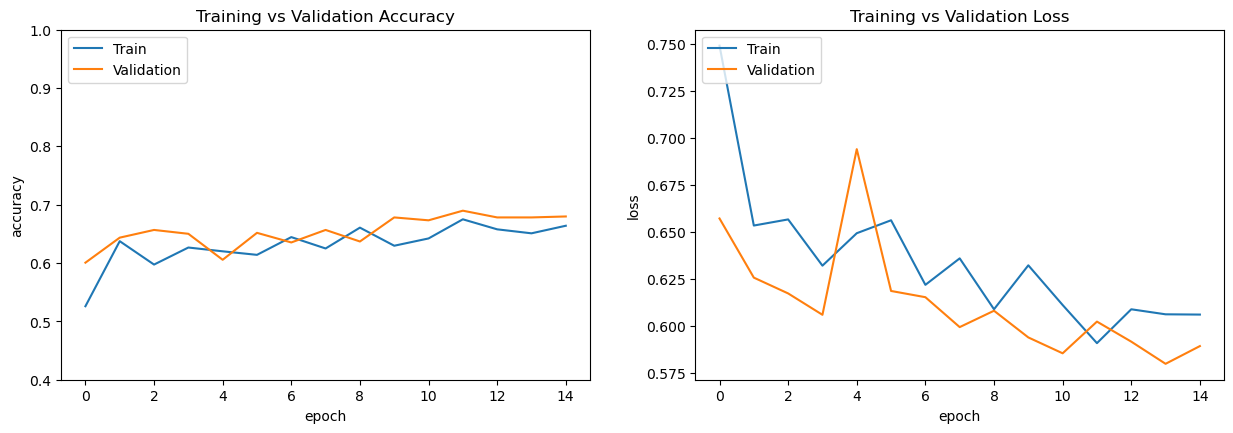

In [45]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

# Predictions

In order to evaluate the quality of the trained model, the outcome was predicted from the test (validation) data and compared with the observed value. **The threshold was set as 0.5 and the predicted value of more than 0.5 was treated as 1, which is positive.**

In [46]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/mammography_pred_model.h5')

In [47]:
pred = model.predict(validation_generator)

38/38 [==============================] - 8s 185ms/step


In [48]:
# prediction by the AI
pred

array([[0.7490874 ],
       [0.83093584],
       [0.643158  ],
       [0.48138022],
       [0.70421857],
       [0.19678698],
       [0.4545213 ],
       [0.59094274],
       [0.62925094],
       [0.8187634 ],
       [0.39264575],
       [0.52375007],
       [0.53217083],
       [0.83593875],
       [0.8596291 ],
       [0.82826054],
       [0.7481827 ],
       [0.8054253 ],
       [0.57201827],
       [0.5651201 ],
       [0.8481681 ],
       [0.68737996],
       [0.41572455],
       [0.79479045],
       [0.71147686],
       [0.49731588],
       [0.7877975 ],
       [0.44925874],
       [0.47529823],
       [0.6733639 ],
       [0.68057597],
       [0.78910863],
       [0.69661504],
       [0.5574001 ],
       [0.4374856 ],
       [0.8728463 ],
       [0.20704576],
       [0.51431006],
       [0.21559826],
       [0.83471155],
       [0.86405885],
       [0.4621134 ],
       [0.2785472 ],
       [0.59365547],
       [0.7552176 ],
       [0.7782144 ],
       [0.46109077],
       [0.731

In [49]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [50]:
print(y_pred)

[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 

In [51]:
pd.Series(y_pred).value_counts()

1    420
0    186
dtype: int64

In [52]:
y_true = validation_generator.classes

In [53]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

# Confusion Matrix

Confusion matrix was created with the predicted and observed values. The matrix indicated almost correct predictions by the trained model except that there were two cases observed as false positive. False positive means that a case is actually negative but predicted as positive.

In [54]:
cm = confusion_matrix(y_true, y_pred)

Text(50.722222222222214, 0.5, 'Truth')

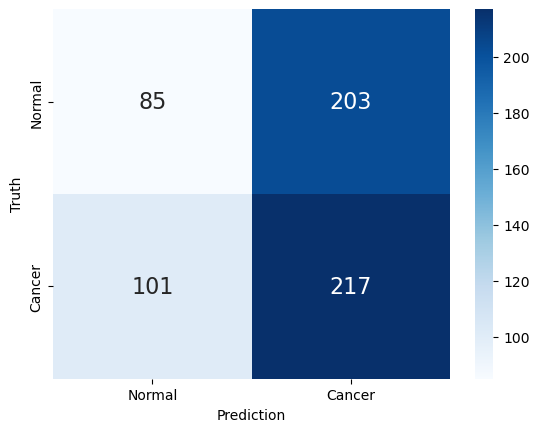

In [55]:
# Define the class names.
class_names = ['Normal', 'Cancer']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

# Classification Report

Classification report describes precision, recall, and f1-score as to each value. Many people regard accuracy and f1-score as the most important indicator to evaluate an AI model. This may be correct, but is not necessarily correct in the clinical field. **It must be considered why AI can be useful for and accepted by healthcare professionals. They expect that AI may be able to reduce their workload.** What does it mean to reduce their workload by AI? One idea is to **exclude lots of negative cases by AI that healthcare professionals would not have to see in order that they would be able to concentrate on the remaining positive cases to be treated**. Thus, it is required that the AI should be able to **exclude negative cases without false negatives**, which are actually positive but predicted as negative. **Otherwise, they would have to re-check the negative cases in order not to miss actually positive cases.** They must absolutely avoid clinical negligence! Therefore, **if the AI model does not give rise to false negative cases, the model will be considerably acceptable in the healthcare field** regardless of the accuracy or f1-score.

In [56]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.30      0.36       288
           1       0.52      0.68      0.59       318

    accuracy                           0.50       606
   macro avg       0.49      0.49      0.47       606
weighted avg       0.49      0.50      0.48       606



# Analysing the Results

It is crucial in the medical field to analyze what kinds of cases were misclassified by the AI model, because medical misdiagnosis must be avoided as much as possible. Thus, it is necessary to identify false positive and false negative cases. Making a data frame and confusion table can visualize the results. As discussed above, false negative cases must be particularly avoided.

In [57]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [58]:
print(confusion)

['FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP

In [59]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,FP
1,FP
2,FP
3,TN
4,FP
...,...
601,FN
602,TP
603,FN
604,TP


In [60]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,1,0,FP
1,1,0,FP
2,1,0,FP
3,0,0,TN
4,1,0,FP
...,...,...,...
601,0,1,FN
602,1,1,TP
603,0,1,FN
604,1,1,TP


In [61]:
confusion_table.Results == 'FP'

0       True
1       True
2       True
3      False
4       True
       ...  
601    False
602    False
603    False
604    False
605    False
Name: Results, Length: 606, dtype: bool

In [62]:
# list of false positive images
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
0,1,0,FP
1,1,0,FP
2,1,0,FP
4,1,0,FP
7,1,0,FP
...,...,...,...
283,1,0,FP
284,1,0,FP
285,1,0,FP
286,1,0,FP


In [63]:
FPs.index

Int64Index([  0,   1,   2,   4,   7,   8,   9,  11,  12,  13,
            ...
            272, 275, 276, 278, 279, 283, 284, 285, 286, 287],
           dtype='int64', length=203)

In [64]:
# list of false negative images
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results
294,0,1,FN
297,0,1,FN
299,0,1,FN
302,0,1,FN
303,0,1,FN
...,...,...,...
588,0,1,FN
599,0,1,FN
600,0,1,FN
601,0,1,FN


In [65]:
FNs.index

Int64Index([294, 297, 299, 302, 303, 304, 307, 308, 312, 314,
            ...
            570, 571, 575, 579, 584, 588, 599, 600, 601, 603],
           dtype='int64', length=101)

# Misclassficiation Cases

It is impoertant to pick up wrong cases judged by the AI and to analyze why the AI made wrong judgements for these images.

In [66]:
import glob
val_images = glob.glob('/kaggle/working/val/*/*.png')

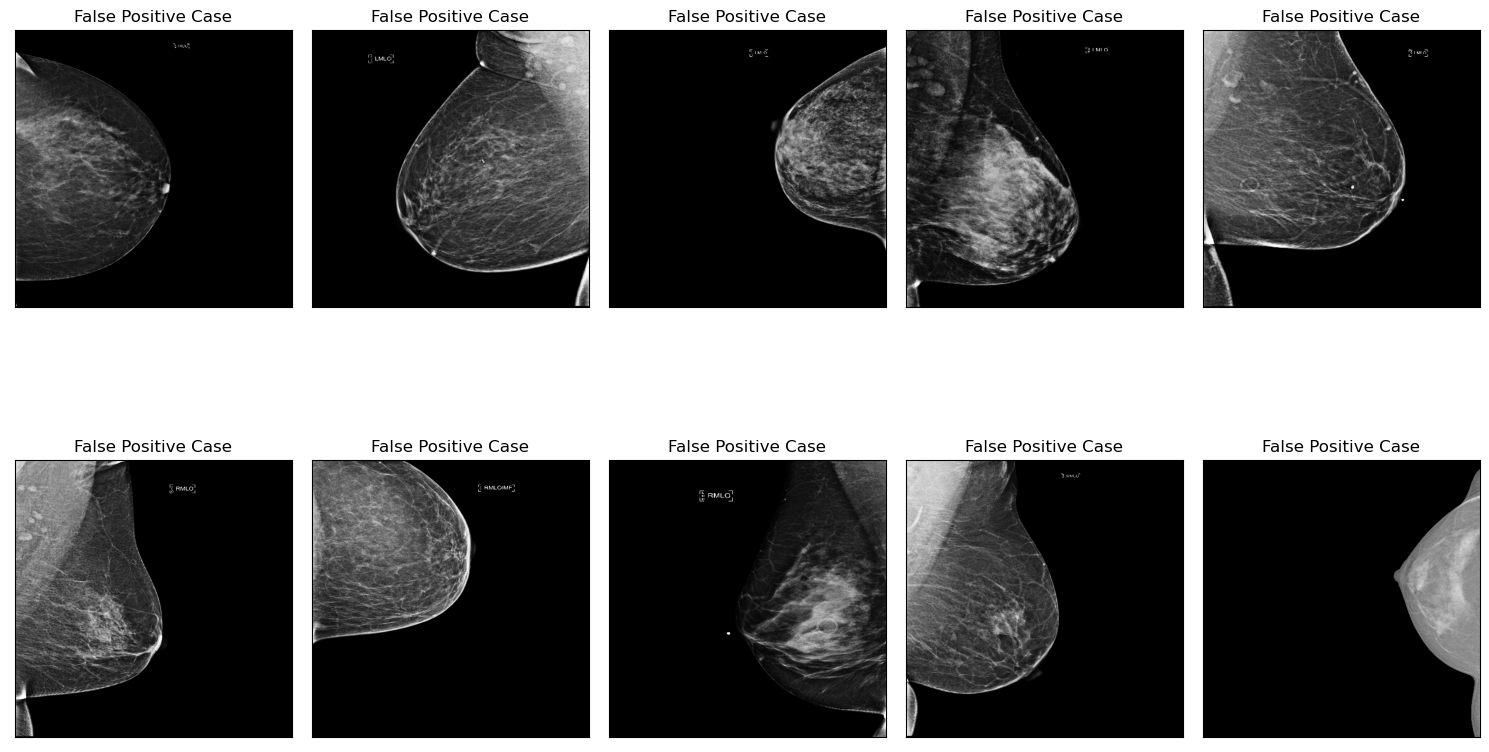

In [67]:
# False positive imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

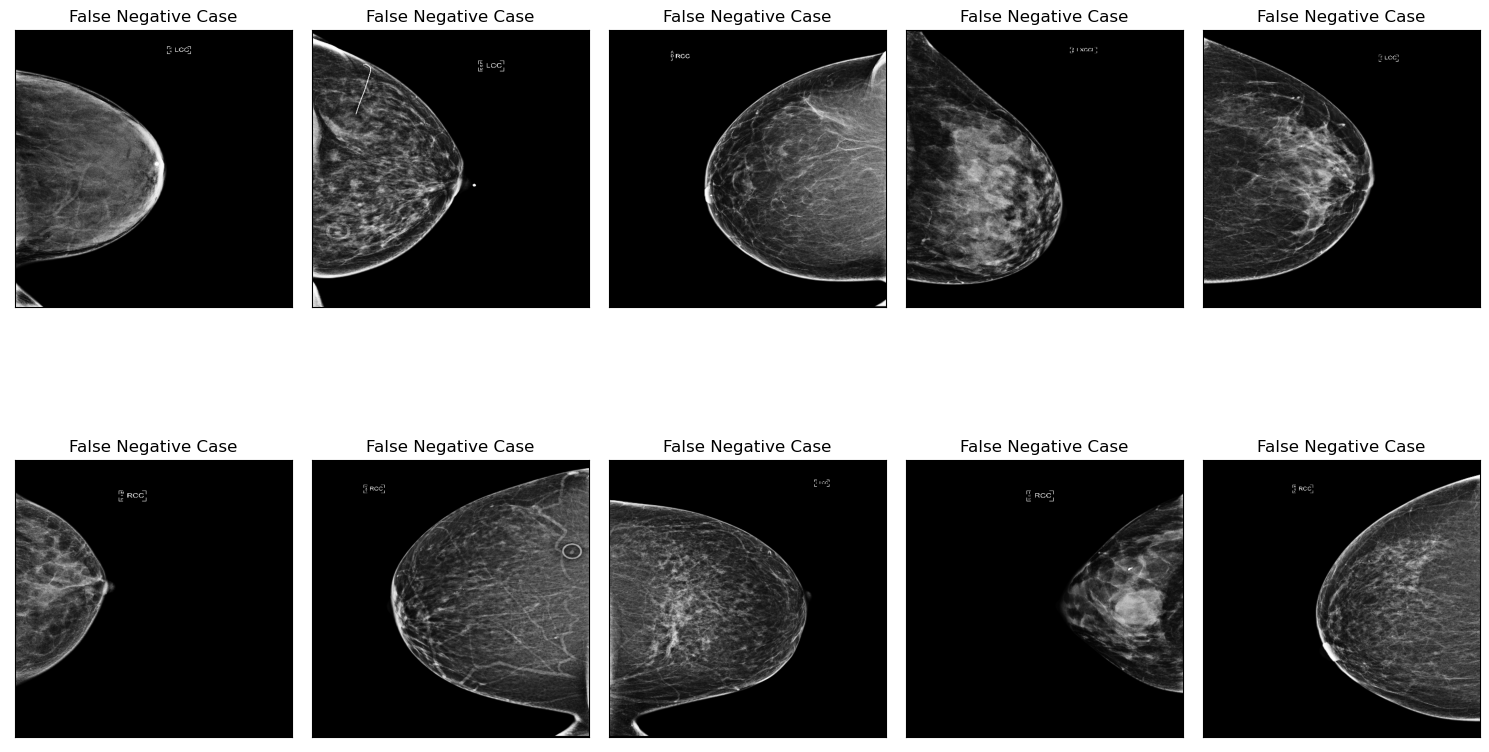

In [68]:
# False negative imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FNs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Negative Case")
fig.tight_layout()    

plt.show()

# Finetuning the Model (Unfreeying the Layers of the Model)

In [69]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = True # Change from False to True.
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 23,781,761
Non-trainable params: 45,440
_____________________________________

In [71]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15
20/20 [==============================] - 78s 2s/step - loss: 0.7842 - accuracy: 0.5812 - val_loss: 21735.1758 - val_accuracy: 0.4752
Epoch 2/15
20/20 [==============================] - 48s 2s/step - loss: 0.6850 - accuracy: 0.5487 - val_loss: 12936.3369 - val_accuracy: 0.5248
Epoch 3/15
20/20 [==============================] - 50s 2s/step - loss: 0.6972 - accuracy: 0.5906 - val_loss: 4061.8242 - val_accuracy: 0.4752
Epoch 4/15
20/20 [==============================] - 49s 2s/step - loss: 0.6729 - accuracy: 0.6313 - val_loss: 0.7039 - val_accuracy: 0.5066
Epoch 5/15
20/20 [==============================] - 48s 2s/step - loss: 0.6506 - accuracy: 0.6039 - val_loss: 7.7904 - val_accuracy: 0.5693
Epoch 6/15
20/20 [==============================] - 48s 2s/step - loss: 0.6758 - accuracy: 0.6282 - val_loss: 568.3904 - val_accuracy: 0.4752
Epoch 7/15
20/20 [==============================] - 49s 2s/step - loss: 0.6572 - accuracy: 0.6250 - val_loss: 5.1775 - val_accuracy: 0.4752
Epoch 8

In [72]:
# This time we use validation data to calculate the final accuracy.
final_accuracy = model.evaluate_generator(validation_generator)[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [73]:
final_accuracy

0.5346534848213196

# Model Metrics

In [74]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss

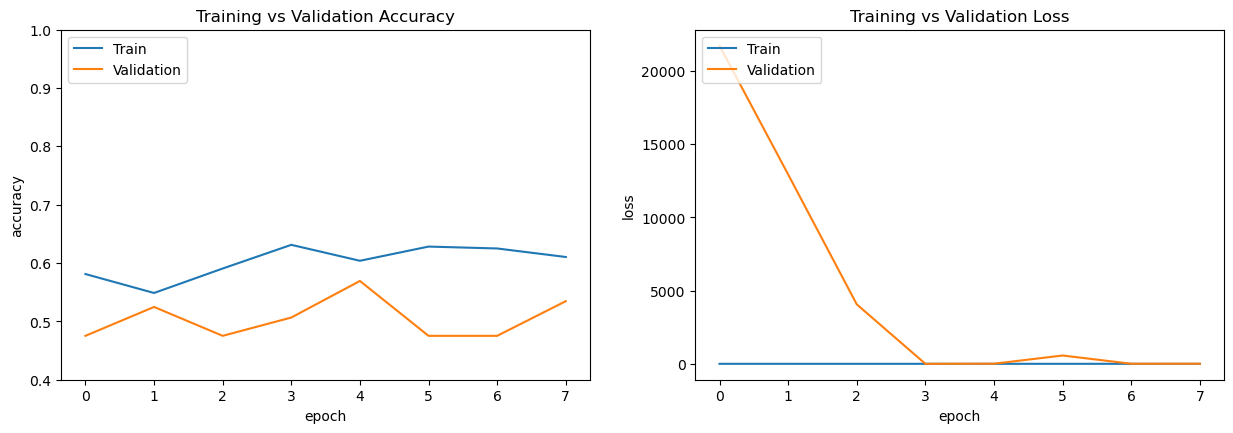

In [75]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# Actually, Finetuning is worse than Transfer Learning, because the number of data images is small!

# Save the Model

In [76]:
model.save('mammography_pred_model_finetuning.h5')

# Conclusion

This AI model may be useful for general physicians who occasionally see female patients for the screening purpose. Further improvement is required to prevent misdiagnosis and unnecessary treatment.